# Load data

In [66]:
import os
import numpy as np
from lib.eval.regression import normalize
from lib.zero_shot import get_gap_ids
from lib.utils import mkdir_p

# setup
seed = 123
rng = np.random.RandomState(seed)
data_dir = 'data/' #'../wgan/data/' 
codes_dir = os.path.join(data_dir, 'codes/')
figs_dir = 'figs/'
mkdir_p(figs_dir)

n_c = 10
zshot = True

model_names = ['PCA', 'VAE', '$\\beta$-VAE', 'InfoGAN']
exp_names = [m.lower() for m in model_names]
n_models = len(model_names)
train_fract, dev_fract, test_fract = 0.8, 0.1, 0.1

# load inputs (model codes)
m_codes = []
for n in exp_names:
    try:
        m_codes.append(np.load(os.path.join(codes_dir, n + '.npy')))
    except IOError:
        # .npz, e.g. pca with keys: codes, explained_variance
        m_codes.append(np.load(os.path.join(codes_dir, n + '.npz'))['codes'])

# load targets (ground truths)
gts = np.load(os.path.join(data_dir, 'teapots.npz'))['gts']
n_samples = gts.shape[0]
n_z = gts.shape[1]
n_train, n_dev, n_test = int(train_fract*n_samples), int(dev_fract*n_samples), int(test_fract*n_samples)

# create 'gap' in data if zeroshot (unseen factor combinations)
if zshot:
    try:
        gap_ids = np.load(os.path.join(data_dir, 'gap_ids.npy'))
    except IOError:
        gap_ids = get_gap_ids(gts)
    def create_gap(data):
        return np.delete(data, gap_ids, 0)
    
# split inputs and targets into sets: [train, dev, test, (zeroshot)]
def split_data(data):
    train = data[:n_train]
    dev = data[n_train: n_train + n_dev]
    test = data[n_train + n_dev: n_train + n_dev + n_test]
    if zshot:
        return [create_gap(train), create_gap(dev), create_gap(test), data[gap_ids]]
    return [train, dev, test, None]

gts = split_data(gts)
for i in range(n_models):
    m_codes[i] = split_data(m_codes[i])    

# normalize input and target datasets [train, dev, test, (zeroshot)]
def normalize_datasets(datasets):
    datasets[0], mean, std, _ = normalize(datasets[0], remove_constant=False)
    datasets[1], _, _, _ = normalize(datasets[1], mean, std, remove_constant=False)
    datasets[2], _, _, _ = normalize(datasets[2], mean, std, remove_constant=False)
    if zshot:
        datasets[3], _, _, _ = normalize(datasets[3], mean, std, remove_constant=False)
    return datasets

gts = normalize_datasets(gts)
for i in range(n_models):
    m_codes[i] = normalize_datasets(m_codes[i])

/home/cian/miniconda3/envs/style/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


# Regression

### Fit regressor, visualise and quantify criteria

In [12]:
import matplotlib.pyplot as plt
# %matplotlib inline
from lib.eval.hinton import hinton
from lib.eval.regression import *

def fit_visualise_quantify(regressor, params, err_fn, importances_attr, test_time=False, save_plot=False):
    # lists to store scores
    m_disent_scores   = [] * n_models
    m_complete_scores = [] * n_models
    
    # arrays to store errors (+1 for avg)
    train_errs = np.zeros((n_models, n_z + 1))
    dev_errs   = np.zeros((n_models, n_z + 1))
    test_errs  = np.zeros((n_models, n_z + 1)) 
    zshot_errs = np.zeros((n_models, n_z + 1))
    
    # init plot (Hinton diag)
    fig, axs = plt.subplots(1,n_models, figsize=(12, 6), facecolor='w', edgecolor='k')
    axs = axs.ravel()
    
    for i in range(n_models):
        # init inputs
        X_train, X_dev, X_test, X_zshot = m_codes[i][0], m_codes[i][1], m_codes[i][2], m_codes[i][3]
           
        # R_ij = relative importance of c_i in predicting z_j
        R = [] 
        
        for j in range(n_z):
            # init targets [shape=(n_samples, 1)]
            y_train = gts[0][:, j]
            y_dev   = gts[1][:, j]
            y_test  = gts[2][:, j] if test_time else None
            y_zshot = gts[3][:, j] if zshot else None
            
            # fit model
            model = regressor(**params[i][j])
            model.fit(X_train, y_train)

            # predict
            y_train_pred = model.predict(X_train)
            y_dev_pred   = model.predict(X_dev)
            y_test_pred  = model.predict(X_test) if test_time else None
            y_zshot_pred = model.predict(X_zshot) if zshot else None
            
            # calculate errors
            train_errs[i, j] = err_fn(y_train_pred, y_train)
            dev_errs[i, j]   = err_fn(y_dev_pred, y_dev)
            test_errs[i, j]  = err_fn(y_test_pred, y_test) if test_time else None
            zshot_errs[i, j] = err_fn(y_zshot_pred, y_zshot) if zshot else None            
            
            # extract relative importance of each code variable in predicting z_j
            r = getattr(model, importances_attr)[:, None] # [n_c, 1]
            R.append(np.abs(r))

        R = np.hstack(R) #columnwise, predictions of each z

        # disentanglement
        disent_scores = entropic_scores(R.T)
        c_rel_importance = np.sum(R,1) / np.sum(R) # relative importance of each code variable
        disent_w_avg = np.sum(np.array(disent_scores) * c_rel_importance)
        disent_scores.append(disent_w_avg)
        m_disent_scores.append(disent_scores)

        # completeness
        complete_scores = entropic_scores(R)
        complete_avg = np.mean(complete_scores)
        complete_scores.append(complete_avg)
        m_complete_scores.append(complete_scores)

        # informativeness (append averages)
        train_errs[i, -1] = np.mean(train_errs[i, :-1])
        dev_errs[i, -1]   = np.mean(dev_errs[i, :-1])
        test_errs[i, -1]  = np.mean(test_errs[i, :-1]) if test_time else None
        zshot_errs[i, -1] = np.mean(zshot_errs[i, :-1]) if zshot else None

        # visualise
        hinton(R, '$\mathbf{z}$', '$\mathbf{c}$', ax=axs[i], fontsize=18)
        axs[i].set_title('{0}'.format(model_names[i]), fontsize=20)
    
    plt.rc('text', usetex=True)
    if save_plot:
        fig.tight_layout()
        plt.savefig(os.path.join(figs_dir, "hint_{0}_{1}.pdf".format(regressor.__name__, n_c)))
    else:
        plt.show()

    print_table_pretty('Disentanglement', m_disent_scores, 'c', model_names)
    print_table_pretty('Completeness', m_complete_scores, 'z', model_names)

    print("Informativeness:")
    
    print_table_pretty('Training Error', train_errs, 'z', model_names)
    print_table_pretty('Validation Error', dev_errs, 'z', model_names)
    
    if test_time:
        print_table_pretty('Test Error', test_errs, 'z', model_names)
        if zshot:
            print_table_pretty('Zeroshot Error', zshot_errs, 'z', model_names)

### Lasso

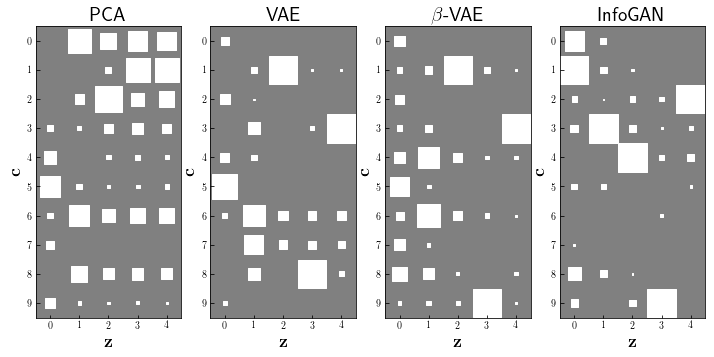

Disentanglement:
	c0	c1	c2	c3	c4	c5	c6	c7	c8	c9	Avg.
PCA	0.16&	0.50&	0.31&	0.09&	0.45&	0.60&	0.11&	1.00&	0.17&	0.51&	0.29&	
VAE	1.00&	0.85&	0.95&	0.68&	0.63&	1.00&	0.30&	0.37&	0.66&	0.95&	0.67&	
$\beta$-VAE	1.00&	0.64&	1.00&	0.76&	0.39&	0.89&	0.49&	0.81&	0.45&	0.80&	0.66&	
InfoGAN	0.83&	0.85&	0.76&	0.66&	0.78&	0.43&	1.00&	1.00&	0.64&	0.74&	0.75&	

Completeness:
	z0	z1	z2	z3	z4	Avg.
PCA	0.38&	0.39&	0.34&	0.24&	0.25&	0.32&	
VAE	0.54&	0.37&	0.75&	0.73&	0.73&	0.62&	
$\beta$-VAE	0.14&	0.39&	0.70&	0.85&	0.88&	0.59&	
InfoGAN	0.42&	0.72&	0.75&	0.86&	0.84&	0.72&	

Informativeness:
Training Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.82&	0.42&	0.31&	0.31&	0.32&	0.44&	
VAE	0.62&	0.60&	0.23&	0.21&	0.21&	0.38&	
$\beta$-VAE	0.80&	0.41&	0.20&	0.19&	0.18&	0.36&	
InfoGAN	0.48&	0.13&	0.17&	0.14&	0.14&	0.21&	

Validation Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.83&	0.42&	0.32&	0.32&	0.33&	0.44&	
VAE	0.62&	0.60&	0.23&	0.21&	0.22&	0.37&	
$\beta$-VAE	0.81&	0.41&	0.19&	0.19&	0.18&	0.35&	
InfoGAN	0.49&	0.13&	0.23&	0.16&	0.15&

In [16]:
from sklearn.linear_model import Lasso

alpha = 0.02
params = [[{"alpha": alpha}] * n_z] * n_models # constant alpha for all models and targets
importances_attr = 'coef_' # weights
err_fn = nrmse # norm root mean sq. error
test_time = True
save_plot = False

fit_visualise_quantify(Lasso, params, err_fn, importances_attr, test_time, save_plot)

### Random Forest

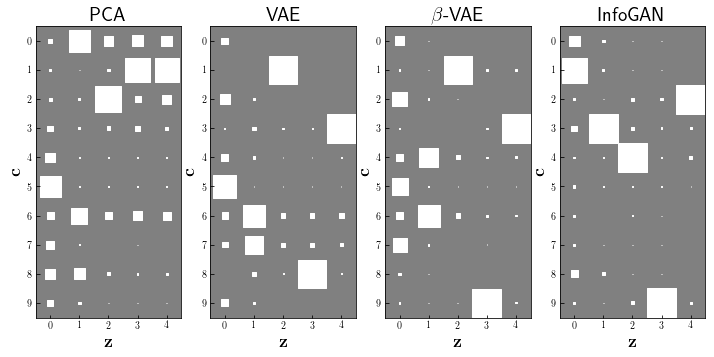

Disentanglement:
	c0	c1	c2	c3	c4	c5	c6	c7	c8	c9	Avg.
PCA	0.25&	0.54&	0.63&	0.10&	0.88&	0.97&	0.16&	0.90&	0.41&	0.72&	0.50&	
VAE	0.98&	0.99&	0.91&	0.94&	0.75&	0.99&	0.56&	0.56&	0.92&	0.86&	0.86&	
$\beta$-VAE	0.96&	0.96&	0.95&	0.99&	0.63&	0.96&	0.69&	0.94&	0.64&	0.98&	0.90&	
InfoGAN	0.85&	0.97&	0.91&	0.84&	0.94&	0.68&	0.86&	0.70&	0.71&	0.92&	0.91&	

Completeness:
	z0	z1	z2	z3	z4	Avg.
PCA	0.31&	0.51&	0.67&	0.56&	0.56&	0.52&	
VAE	0.44&	0.61&	0.90&	0.91&	0.91&	0.75&	
$\beta$-VAE	0.28&	0.67&	0.90&	0.96&	0.97&	0.76&	
InfoGAN	0.59&	0.94&	0.91&	0.96&	0.95&	0.87&	

Informativeness:
Training Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.30&	0.22&	0.17&	0.24&	0.24&	0.24&	
VAE	0.11&	0.07&	0.07&	0.05&	0.05&	0.07&	
$\beta$-VAE	0.13&	0.07&	0.07&	0.08&	0.07&	0.08&	
InfoGAN	0.17&	0.07&	0.08&	0.07&	0.08&	0.09&	

Validation Error:
	z0	z1	z2	z3	z4	Avg.
PCA	0.38&	0.24&	0.20&	0.27&	0.28&	0.27&	
VAE	0.14&	0.08&	0.09&	0.06&	0.06&	0.09&	
$\beta$-VAE	0.17&	0.07&	0.08&	0.09&	0.08&	0.10&	
InfoGAN	0.26&	0.07&	0.14&	0.09&	0.10&

In [15]:
from sklearn.ensemble.forest import RandomForestRegressor

n_estimators = 10
all_best_depths = [[12, 10, 10, 10, 10] , [12, 10, 3, 3, 3], [12, 10, 3, 3, 3], [4, 5, 2, 5, 5]]

# populate params dict with best_depths per model per target (z gt)
params = [[]] * n_models
for i, z_max_depths in enumerate(all_best_depths):
    for z_max_depth in z_max_depths:
        params[i].append({"n_estimators":n_estimators, "max_depth":z_max_depth, "random_state": rng})

importances_attr = 'feature_importances_'
err_fn = nrmse # norm root mean sq. error
test_time = True
save_plot = False

fit_visualise_quantify(RandomForestRegressor, params, err_fn, importances_attr, test_time, save_plot)

# Figs

## z vs. c

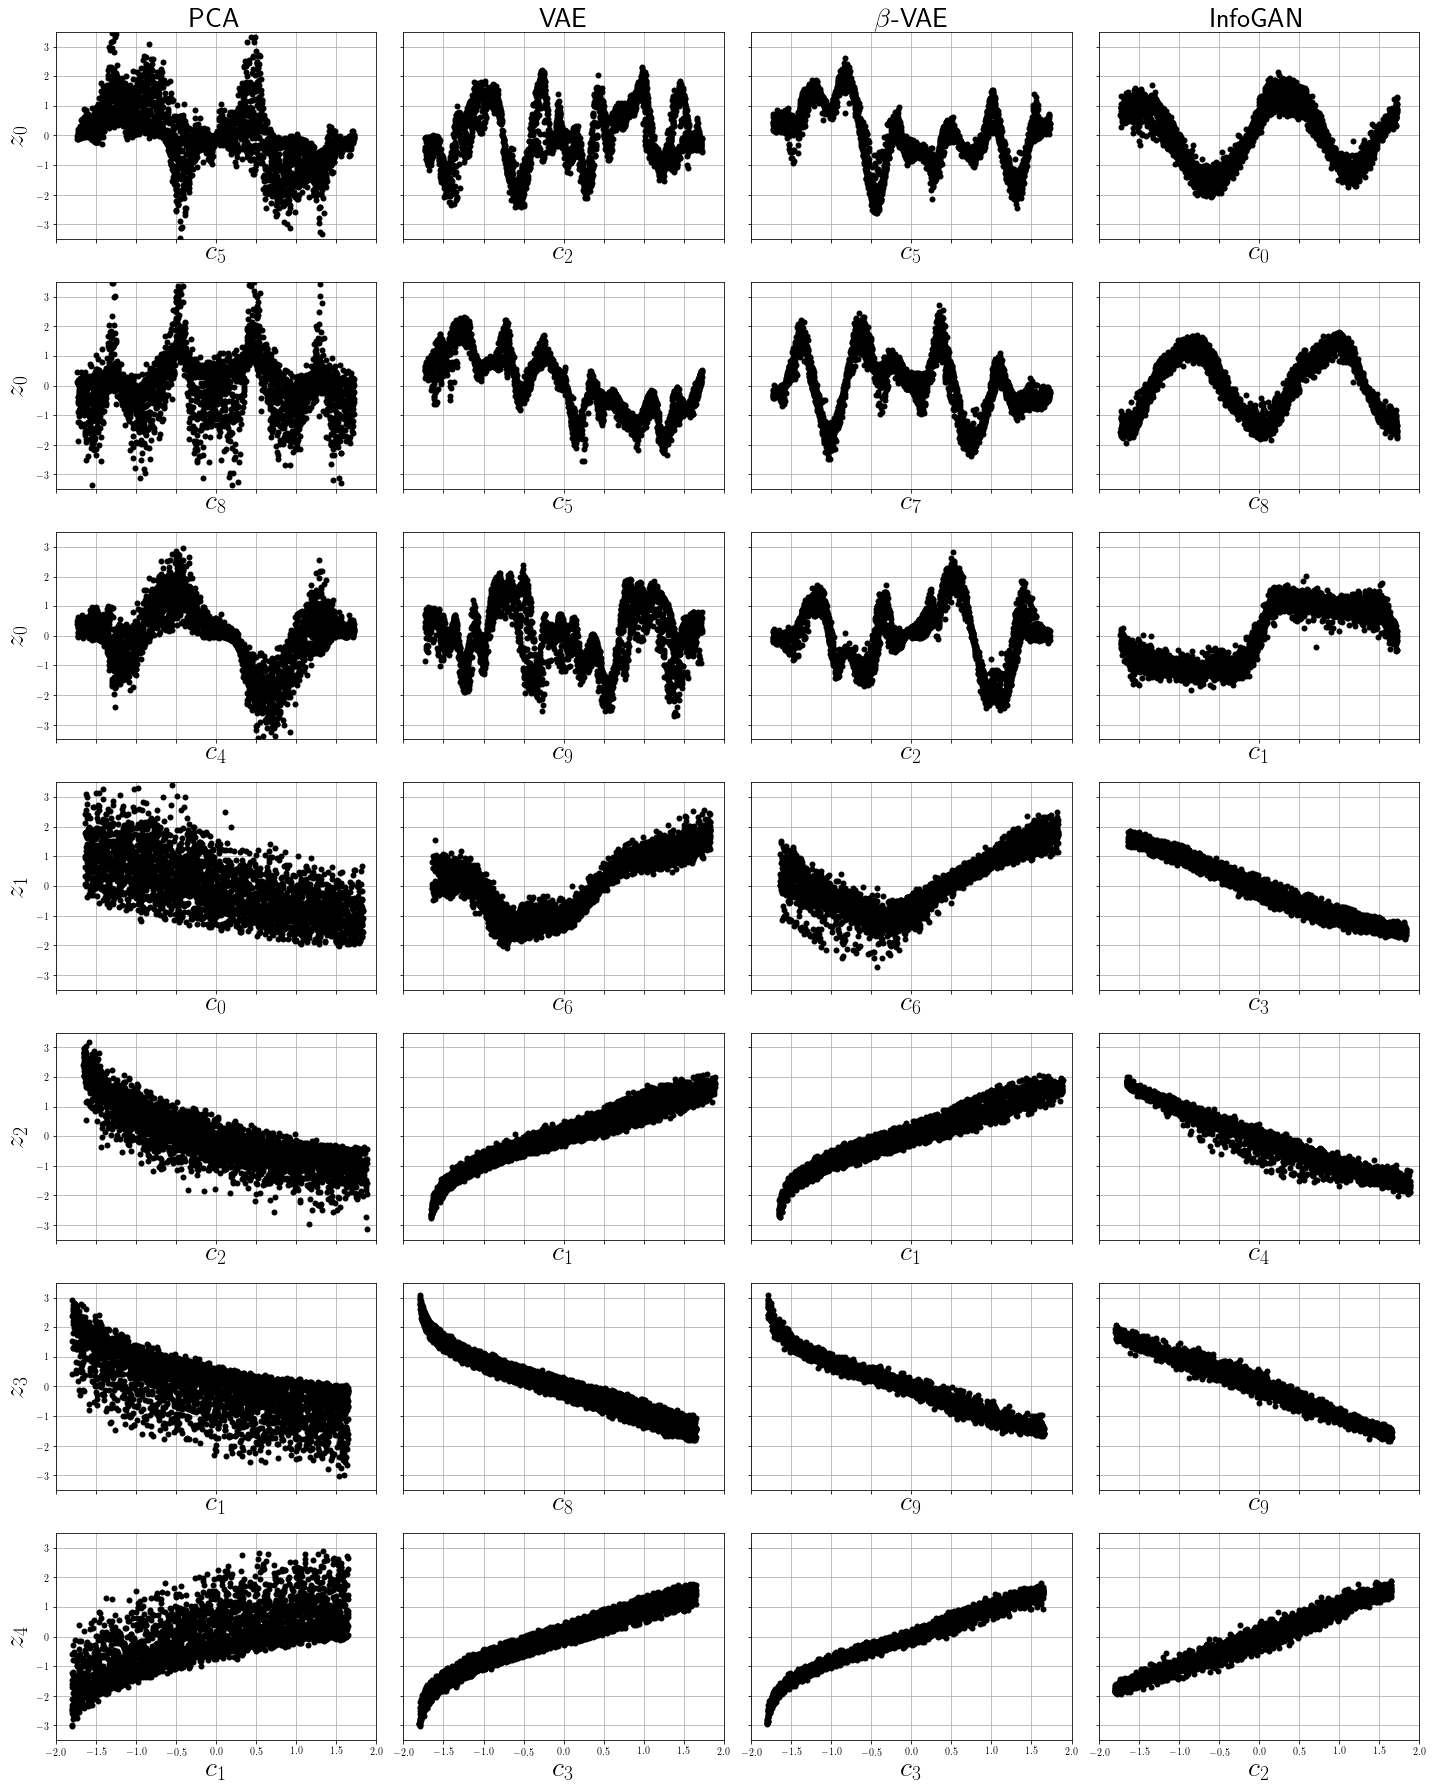

In [67]:
from matplotlib.transforms import offset_copy

zs = [0,0] + list(range(n_z))
all_import_codes = [[5,8,4,0,2,1,1],[2,5,9,6,1,8,3],[5,7,2,6,1,9,3],[0,8,1,3,4,9,2]]
n_samples = 5000
fig, axs = plt.subplots(len(zs), n_models, figsize=(20, 25), facecolor='w', edgecolor='k', sharey=True, sharex=True)

for i, import_codes in zip(range(n_models), all_import_codes):
    X_train = m_codes[i][0]    
    for j, (z, c) in enumerate(zip(zs, import_codes)):
        X = X_train[:, c:c+1]
        y = gts[0][:, z]
        X, y = subset_of_data(X, y, n_samples)
        
        if i == 0: # set column titles
            axs[j,i].set_ylabel('$z_{0}$'.format(z), fontsize=28)
        
        if j == 0:
            axs[j,i].set_title('{0}'.format(model_names[i]), fontsize=28)

        axs[j,i].set_xlabel('$c_{0}$'.format(c), fontsize=28)
        axs[j,i].scatter(y, X, color='black', linewidth=0)        
        axs[j,i].legend(loc=1, fontsize=21)
        axs[j,i].set_ylim([-3.5,3.5])
        axs[j,i].set_xlim([-2,2])
        axs[j,i].grid(True)
        axs[j,i].set_axisbelow(True)

plt.rc('text', usetex=True)
fig.tight_layout()
#plt.show()
plt.savefig(os.path.join(figs_dir, "cvsz.pdf"))

## Visual disentanglement

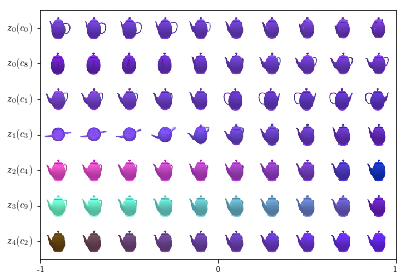

In [65]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
#%matplotlib inline

base = "/home/cian/wgan/papers/images"
models = ["vae", "bvae", "infogan"]
fs = ["traverse{0}".format(m) for m in models]
paths = [os.path.join(base, f) for f in fs]

zs = [0,0] + list(range(5))
all_important_cs = [[2,5,9,6,1,8,3],[5,7,2,6,1,9,3],[0,8,1,3,4,9,2]]
all_xlabels = [[-3, 0, 3], [-3, 0, 3], [-1, 0, 1]]
xlocs = [0, 320, 640]

ylabels = ['$z_{0}$'.format(z) for z in zs]
ylocs = [64*(z+1) - 32 for z in range(len(labels))]

for p, important_cs, xlabels in zip(paths, all_important_cs, all_xlabels):
    ylbls = [ylabels[i] + "$(c_{0})$".format(important_cs[i]) for i in range(len(ylabels))]
    image = mpimg.imread(p + ".png")
    plt.imshow(image)
    plt.yticks(ylocs, ylbls)
    plt.xticks(xlocs, xlabels, fontsize=8)
    plt.tight_layout()
    plt.savefig(os.path.join(base, p + ".pdf"), dpi=700)